In [1]:
import os
import sys
from dotenv import find_dotenv

# adds project directory to syspath to use python code from project directory in notebook
sys.path.append(os.path.dirname(find_dotenv()))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, ConfusionMatrixDisplay
from xgboost import XGBClassifier

from lib.constants import DATASET_PATH
from lib.config import EDUCATION_MAPPING, OUTCOME_MAPPING, ALL_COLUMNS, JOB_IMPUTATION_PARAMS_DICT, COMMUNICATION_IMPUTATION_PARAMS_DICT, ONE_HOT_ENCODING_COLUMNS, SCALABLE_NUMERIC_COLUMNS
from lib.transformers import CallDurationInMinutesTransformer, CallDurationInSecondsTransformer, OrdinalMappingTransformer, SelectFeaturesTransformer, SimpleImputationTransformer
from lib.trainer import run_classification_grid_search

In [3]:
car_insurance_dataset = pd.read_csv(DATASET_PATH)
car_insurance_dataset.shape

(4000, 19)

In [4]:
strat_train_set, strat_test_set = train_test_split(
    car_insurance_dataset, test_size=0.2, stratify=car_insurance_dataset['CarInsurance'], random_state=42)

strat_train_set.shape, strat_test_set.shape

((3200, 19), (800, 19))

In [5]:
car_insurance = car_insurance_dataset.drop('CarInsurance', axis=1)
car_insurance_labels = car_insurance_dataset['CarInsurance'].copy()

In [6]:
car_insurance.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56


In [7]:
feature_engineering_pipeline = make_pipeline(
    CallDurationInMinutesTransformer(),
    CallDurationInSecondsTransformer(),
    OrdinalMappingTransformer(feature_column='Education', mapping_dict=EDUCATION_MAPPING),
    OrdinalMappingTransformer(feature_column='Outcome', mapping_dict=OUTCOME_MAPPING),
    SimpleImputationTransformer(feature_column='Job', imputation_params_dict=JOB_IMPUTATION_PARAMS_DICT),
    SimpleImputationTransformer(feature_column='Communication', imputation_params_dict=COMMUNICATION_IMPUTATION_PARAMS_DICT),
    SelectFeaturesTransformer(features=ALL_COLUMNS),
)

features = feature_engineering_pipeline.fit_transform(car_insurance)
features.head()

,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CallDurationMins,CallDurationSecs,Age,Balance,Job,Marital,Communication,LastContactMonth,Default,HHInsurance,CarLoan,Outcome
0,28,2,-1,0,1,70,32,1218,management,single,telephone,jan,0,1,0,0
1,26,5,-1,0,3,185,32,1156,blue-collar,married,unknown,may,0,1,0,0
2,3,1,119,1,5,340,29,637,management,single,cellular,jun,0,1,0,0
3,11,2,-1,0,13,819,25,373,student,single,cellular,may,0,1,0,0
4,3,1,-1,0,3,192,30,2694,management,married,cellular,jun,0,0,0,0


In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LastContactDay    4000 non-null   int64 
 1   NoOfContacts      4000 non-null   int64 
 2   DaysPassed        4000 non-null   int64 
 3   PrevAttempts      4000 non-null   int64 
 4   CallDurationMins  4000 non-null   int64 
 5   CallDurationSecs  4000 non-null   int64 
 6   Age               4000 non-null   int64 
 7   Balance           4000 non-null   int64 
 8   Job               4000 non-null   object
 9   Marital           4000 non-null   object
 10  Communication     4000 non-null   object
 11  LastContactMonth  4000 non-null   object
 12  Default           4000 non-null   int64 
 13  HHInsurance       4000 non-null   int64 
 14  CarLoan           4000 non-null   int64 
 15  Outcome           4000 non-null   int64 
dtypes: int64(12), object(4)
memory usage: 500.1+ KB


In [9]:
encoder_pipeline = ColumnTransformer([
    ('categorical_encoding', OneHotEncoder(), ONE_HOT_ENCODING_COLUMNS),
    ('numerical_scaling', StandardScaler(), SCALABLE_NUMERIC_COLUMNS),
], remainder='passthrough')

feature_vector_pipeline = make_pipeline(
    feature_engineering_pipeline,
    encoder_pipeline,
)

In [10]:
GRID_SEARCH_PARAMS = {
    'Linear SVM': (SVC(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {}),
    'Random Forest': (RandomForestClassifier(), {}),
    'Neural Net': (MLPClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'XGB': (XGBClassifier(objective='binary:logistic'), {}),
}

best_score, best_classifier, best_classifier_name, best_params = run_classification_grid_search(
    params_grid=GRID_SEARCH_PARAMS, pipeline=feature_vector_pipeline, X=car_insurance, y=car_insurance_labels)

Running grid search CV for Linear SVM model
Best score: 0.8222245309730188

Running grid search CV for Decision Tree model
Best score: 0.7721905230760898

Running grid search CV for Random Forest model
Best score: 0.915944363082161

Running grid search CV for Neural Net model
Best score: 0.909512896161771

Running grid search CV for AdaBoost model
Best score: 0.9017258705259276

Running grid search CV for Naive Bayes model
Best score: 0.8332381656202058

Running grid search CV for XGB model
Best score: 0.915591803049565



In [11]:
best_classifier

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('calldurationinminutestransformer',
                                                   CallDurationInMinutesTransformer()),
                                                  ('calldurationinsecondstransformer',
                                                   CallDurationInSecondsTransformer()),
                                                  ('ordinalmappingtransformer-1',
                                                   OrdinalMappingTransformer(feature_column='Education',
                                                                             mapping_dict={'primary': 1,
                                                                                           'secondary': 2,
                                                                                           'tertiary'...
                                                                                       'LastContactMonth',
                                                                                       'Default',
                                                                                       'HHInsurance',
                                                                                       'CarLoan',
                                                                                       'Outcome']))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical_encoding',
                                                                   OneHotEncoder(),
                                                                   ['Job',
                                                                    'Marital',
                                                                    'Communication',
                                                                    'LastContactMonth']),
                                                                  ('numerical_scaling',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'Balance'])]))])),
                ('randomforestclassifier', RandomForestClassifier())])

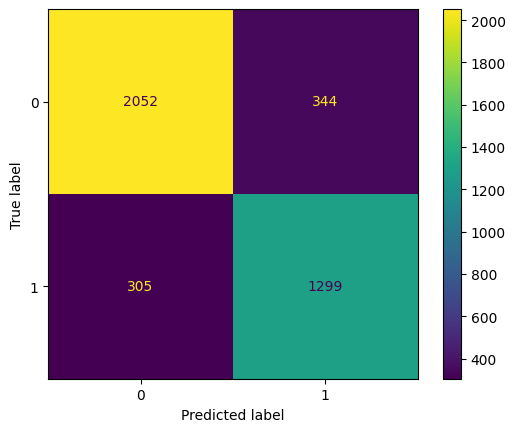

In [12]:
car_insurance_labels_pred = cross_val_predict(best_classifier, car_insurance, car_insurance_labels, cv=3)

ConfusionMatrixDisplay.from_predictions(car_insurance_labels, car_insurance_labels_pred)
plt.show()

In [13]:
precision_score(car_insurance_labels, car_insurance_labels_pred)

0.790626902008521

In [14]:
recall_score(car_insurance_labels, car_insurance_labels_pred)

0.809850374064838